# Dataset and imports

We choose the built-in breast cancer dataset (binary classification).

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=0)

print(f"Training set: {Xtrain.shape, ytrain.shape}")
print(f"Validation set: {Xvalid.shape, yvalid.shape}")
print(f"Test set: {Xtest.shape, ytest.shape}")

Training set: ((318, 30), (318,))
Validation set: ((137, 30), (137,))
Test set: ((114, 30), (114,))


# Logistic Regression
We now perform LR on this dataset and extract predicted probabilities in order to analyze the influence of established threshold. After that, we calculate the AUC metric (area under ROC curve - the bigger, the better, max=1.0). We start by performing standard LR on the training set and then we use the model to predict the values on the validation set.

In [3]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtrain, ytrain)

ypred = lr_model.predict(Xvalid)
fpr, tpr, thresholds = roc_curve(yvalid, ypred)
roc_auc = auc(fpr, tpr)

accuracy = accuracy_score(yvalid, ypred)
precision = precision_score(yvalid, ypred)
recall = recall_score(yvalid, ypred)
f1 = f1_score(yvalid, ypred)
conf_matrix = confusion_matrix(yvalid, ypred)

print("Validation set performance (threshold = 0.5)")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Confusion matrix:\n{conf_matrix}")


Validation set performance (threshold = 0.5)
Accuracy: 0.9416
Precision: 0.9753
Recall: 0.9294
F1 score: 0.9518
Confusion matrix:
[[50  2]
 [ 6 79]]


Now let's experiment with a couple of different thresholds:

In [4]:
scores_df = pd.DataFrame()
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtrain, ytrain)
thrs = [0.001, 0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99, 0.999]
for threshold in thrs:
    ypred = np.where(lr_model.predict_proba(Xvalid)[:, 1] > threshold, 1., 0.)

    accuracy = accuracy_score(yvalid, ypred)
    precision = precision_score(yvalid, ypred)
    recall = recall_score(yvalid, ypred)
    f1 = f1_score(yvalid, ypred)
    conf_matrix = confusion_matrix(yvalid, ypred)
    
    scores_df[threshold] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
    scores_df.columns.name = 'Threshold'
    scores_df.index.name = 'Metric'

scores_df

Threshold,0.001,0.010,0.050,0.150,0.250,0.500,0.750,0.850,0.950,0.990,0.999
Metric,,,,,,,,,,,
Accuracy,0.934307,0.948905,0.941606,0.941606,0.941606,0.941606,0.912409,0.897810,0.897810,0.846715,0.810219
Precision,0.931818,0.953488,0.952941,0.963855,0.975309,0.975309,0.974026,0.973333,1.000000,1.000000,1.000000
Recall,0.964706,0.964706,0.952941,0.941176,0.929412,0.929412,0.882353,0.858824,0.835294,0.752941,0.694118
F1-score,0.947977,0.959064,0.952941,0.952381,0.951807,0.951807,0.925926,0.912500,0.910256,0.859060,0.819444


We can observe that varying the threshold changes the performance of the model.

Given the False Positive Rate and True Positive Rate (building blocks of ROC curve) we can now extract the best possible threshold. We want to simultaneously minimize FPR and maximize TPR and in order to do so, we have to use some heuristics.

Our choice here would be to simply minimize the (euclidean) distance od ROC curve point from $(FPR, TPR) = (0, 1)$ (top-left corner).

In [11]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtrain, ytrain)

ypred = lr_model.predict_proba(Xvalid)[:, 1]
fpr, tpr, thresholds = roc_curve(yvalid, ypred)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
roc_df['dist_to_(0, 1)'] = np.sqrt((roc_df['fpr'] - 0.0)**2 + (roc_df['tpr'] - 1.0)**2)
roc_df = roc_df.sort_values('dist_to_(0, 1)')
best_fpr_tpr = roc_df.iloc[0, [0, 1]].values
best_threshold = roc_df.iloc[0, 2]

print(f"AUC score: {roc_auc:.4f}")
print(f"Best FPR: {best_fpr_tpr[0]:.4f}")
print(f"Best TPR: {best_fpr_tpr[1]:.4f}")
print(f"Best threshold: {best_threshold:.4f}")

AUC score: 0.9887
Best FPR: 0.0577
Best TPR: 0.9529
Best threshold: 0.1470


We visualize the described method on the ROC plot below. The ROC curve is the threshold-parametrized $(FPR(thr), TPR(thr))$ curve: for every possible threshold level $thr\in[0, 1]$ we estimate the model, extract the aforementioned metrics and plot them against one another.

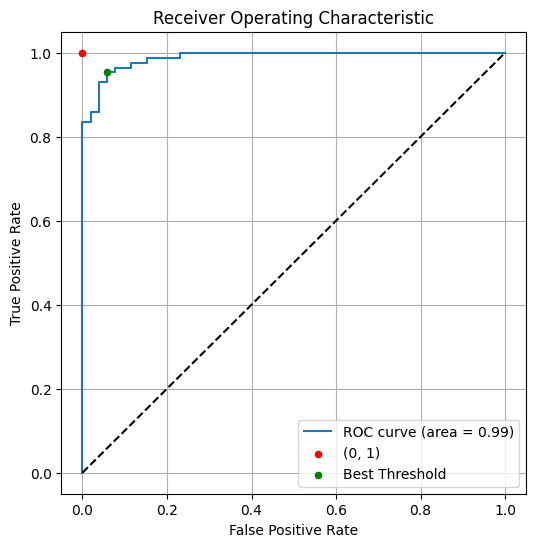

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.grid(visible=True)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')

ax.scatter(0.0, 1.0, c='red', s=20, zorder=10, label='(0, 1)')
ax.scatter(best_fpr_tpr[0], best_fpr_tpr[1], c='green', s=20, zorder=10, label='Best Threshold')

ax.legend()
plt.show()

We now apply the best threshold to test set and compute the metrics:

In [13]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtest, ytest)
ypred = np.where(lr_model.predict_proba(Xtest)[:, 1] > best_threshold, 1, 0)

accuracy = accuracy_score(ytest, ypred)
precision = precision_score(ytest, ypred)
recall = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)
conf_matrix = confusion_matrix(ytest, ypred)

The model performs perfectly on the test set!

In [24]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Confusion matrix:\n{conf_matrix}")

Accuracy: 0.9841
Precision: 1.0000
Recall: 0.9696
F1 score: 0.9845
Confusion matrix:
[[210   0]
 [  7 223]]


# New dataset

We actually suspect that there is something wrong with this dataset - the model performs "too well"...

Let's change the dataset:

In [15]:
from sklearn.datasets import fetch_lfw_pairs

In [42]:
data = fetch_lfw_pairs(subset='train')
X, y = data.data[:, :200], data.target # first 200 predictors

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=0)

print(f"Training set: {Xtrain.shape, ytrain.shape}")
print(f"Validation set: {Xvalid.shape, yvalid.shape}")
print(f"Test set: {Xtest.shape, ytest.shape}")

Training set: ((1232, 200), (1232,))
Validation set: ((528, 200), (528,))
Test set: ((440, 200), (440,))


We again show the dataframe with metrics given thresholds:

In [43]:
scores_df = pd.DataFrame()
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtrain, ytrain)
thrs = [0.001, 0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99, 0.999]
for threshold in thrs:
    ypred = np.where(lr_model.predict_proba(Xvalid)[:, 1] > threshold, 1., 0.)

    accuracy = accuracy_score(yvalid, ypred)
    precision = precision_score(yvalid, ypred)
    recall = recall_score(yvalid, ypred)
    f1 = f1_score(yvalid, ypred)
    conf_matrix = confusion_matrix(yvalid, ypred)
    
    scores_df[threshold] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
    scores_df.columns.name = 'Threshold'
    scores_df.index.name = 'Metric'

scores_df

Threshold,0.001,0.010,0.050,0.150,0.250,0.500,0.750,0.850,0.950,0.990,0.999
Metric,,,,,,,,,,,
Accuracy,0.481061,0.486742,0.486742,0.509470,0.501894,0.539773,0.511364,0.524621,0.522727,0.522727,0.520833
Precision,0.480076,0.482824,0.482625,0.493927,0.489177,0.517241,0.472527,0.520000,0.571429,1.000000,0.000000
Recall,1.000000,1.000000,0.988142,0.964427,0.893281,0.592885,0.169960,0.102767,0.015810,0.003953,0.000000
F1-score,0.648718,0.651223,0.648508,0.653280,0.632168,0.552486,0.250000,0.171617,0.030769,0.007874,0.000000


Calculate things to get best threshold and then plot the ROC curve:

AUC score: 0.5426
Best FPR: 0.4327
Best TPR: 0.5455
Best threshold: 0.538826


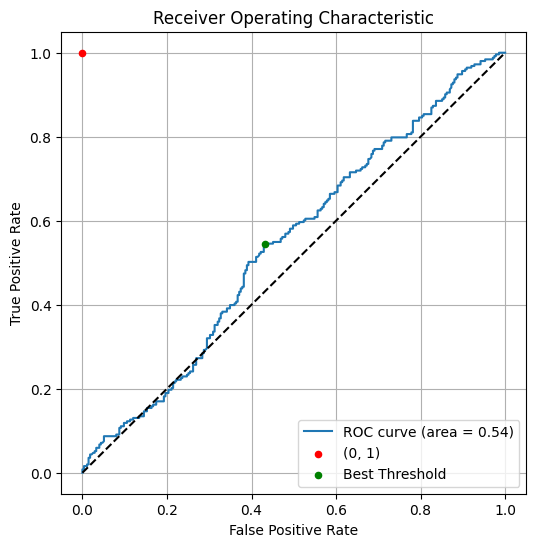

In [44]:
ypred = lr_model.predict_proba(Xvalid)[:, 1]
fpr, tpr, thresholds = roc_curve(yvalid, ypred)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
roc_df['dist_to_(0, 1)'] = np.sqrt((roc_df['fpr'] - 0.0)**2 + (roc_df['tpr'] - 1.0)**2)
roc_df = roc_df.sort_values('dist_to_(0, 1)')
best_fpr_tpr = roc_df.iloc[0, [0, 1]].values
best_threshold = roc_df.iloc[0, 2]

print(f"AUC score: {roc_auc:.4f}")
print(f"Best FPR: {best_fpr_tpr[0]:.4f}")
print(f"Best TPR: {best_fpr_tpr[1]:.4f}")
print(f"Best threshold: {best_threshold:.6f}")

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.grid(visible=True)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')

ax.scatter(0.0, 1.0, c='red', s=20, zorder=10, label='(0, 1)')
ax.scatter(best_fpr_tpr[0], best_fpr_tpr[1], c='green', s=20, zorder=10, label='Best Threshold')

ax.legend()
plt.show()

In [45]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtest, ytest)
ypred = np.where(lr_model.predict_proba(Xtest)[:, 1] > best_threshold, 1, 0)

accuracy = accuracy_score(ytest, ypred)
precision = precision_score(ytest, ypred)
recall = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)
conf_matrix = confusion_matrix(ytest, ypred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Confusion matrix:\n{conf_matrix}")

Accuracy: 0.8205
Precision: 0.8386
Recall: 0.8130
F1 score: 0.8256
Confusion matrix:
[[174  36]
 [ 43 187]]


Here we see an example of situation, in which a small change in the threshold (from 0.5 to 0.54) is suggested to be made to get better performance.